In [2]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

# spikes, behavior, coordinates, df, stimulus = loaddata()

"""
to dump:

path = os.path.dirname(os.getcwd())
pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))

to load:

check1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))
"""

"\nto dump:\n\npath = os.path.dirname(os.getcwd())\npickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))\n\nto load:\n\ncheck1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))\n"

In [4]:
from os import getcwd
from os.path import dirname
dirname(getcwd())

'C:\\Users\\sebas\\OneDrive\\Intern\\rtrbm_master'

In [3]:
n_batches = 100
T = 100
mean_fr = .1
data = torch.zeros(90, T, n_batches)
for batch in range(n_batches):
    t = np.linspace(0, 10*np.pi, T)
    u = np.random.rand(2,)
    fr1 = 2*mean_fr*u[0]*np.sin(t + u[1]) + 2*mean_fr*u[0]
    u = np.random.rand(2,)
    fr2 = 2*mean_fr*u[0]*np.sin(t + u[1]) + 2*mean_fr*u[0]
    u = np.random.rand(2)
    fr3 = 2*mean_fr*u[0]*np.sin(t + u[1]) + 2*mean_fr*u[0]

    mother1 = np.random.poisson(fr1)
    mother2 = np.random.poisson(fr2)
    mother3 = np.random.poisson(fr3)

    #inter-population correlations
    corr = .7
    neurons_per_pop = 30
    n_pop = 3
    spikes = np.zeros((neurons_per_pop*n_pop, T))

    ## population 1

    # delete spikes based on fr mother 3 previous step
    delete_spikes1 = np.roll(fr3, 1) * np.ones((neurons_per_pop, T)) >= np.random.uniform(0, 1, size=(neurons_per_pop, T))
    # add spikes based on fr mother 2 previous step
    noise1 = np.random.poisson(np.roll(fr2, 1), (neurons_per_pop, T))
    spikes[:neurons_per_pop, :] = np.tile(mother1, (neurons_per_pop, 1)) - delete_spikes1 + noise1

    ## population 2

    # delete spikes based on fr mother 3 previous step
    delete_spikes2 = np.roll(fr3, 1) * np.ones((neurons_per_pop, T)) >= np.random.uniform(0, 1, size=(neurons_per_pop, T))
    # add spikes based on fr mother 1 previous step
    noise2 = np.random.poisson(np.roll(fr1, 1), (neurons_per_pop, T))
    spikes[neurons_per_pop:2*neurons_per_pop, :] = np.tile(mother2, (neurons_per_pop, 1)) - delete_spikes2 + noise2

    ## population 3

    corr = .9
    # delete spikes randomly
    delete_spikes3 = corr * np.ones((neurons_per_pop, T)) <= np.random.uniform(0, 1, size=(neurons_per_pop, T))
    # add spikes randomly
    noise3 = np.random.poisson(1-corr, (neurons_per_pop, T))
    spikes[2*neurons_per_pop:, :] = np.tile(mother3, (neurons_per_pop, 1)) - delete_spikes3 + noise3

    
    spikes[spikes < 0] = 0
    spikes[spikes > 1] = 1


    data[:, :, batch] = torch.tensor(spikes)

<AxesSubplot:>

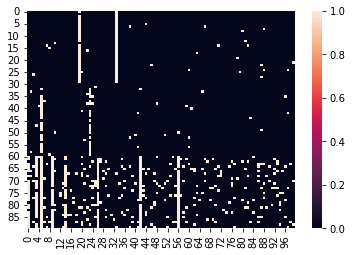

In [4]:
sns.heatmap(data[:,:,7])

In [5]:
rtrbm = RTRBM(data, N_H=3, device='cpu')
rtrbm.learn(n_epochs=500, batchsize=10, lr=1e-3, mom=.7, wc=.0002)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [29:08<00:00,  3.50s/it]


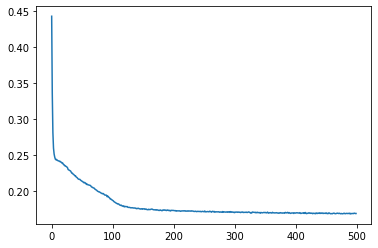

In [6]:
plt.plot(rtrbm.errors)

In [7]:
n_neurons_pop = 30
n_pop = 3
rads = torch.linspace(0, 2*torch.pi, n_pop)
mean_locations_pop = torch.tensor([[-1, 0], [1, 0], [0, 1]])
coordinates = torch.zeros(n_neurons_pop*n_pop, 2)
for i in range(n_pop):
    coordinates[n_neurons_pop * i:n_neurons_pop * (i + 1), :] = 0.15 * torch.randn(n_neurons_pop, 2) + mean_locations_pop[i]

In [13]:
rtrbm.b_H

tensor([[20.4837,  8.4716, 19.9645]])

<AxesSubplot:title={'center':'$U$'}>

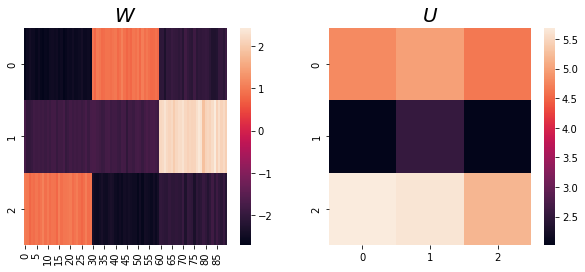

In [10]:
plot_weights(rtrbm.W, rtrbm.W_acc)

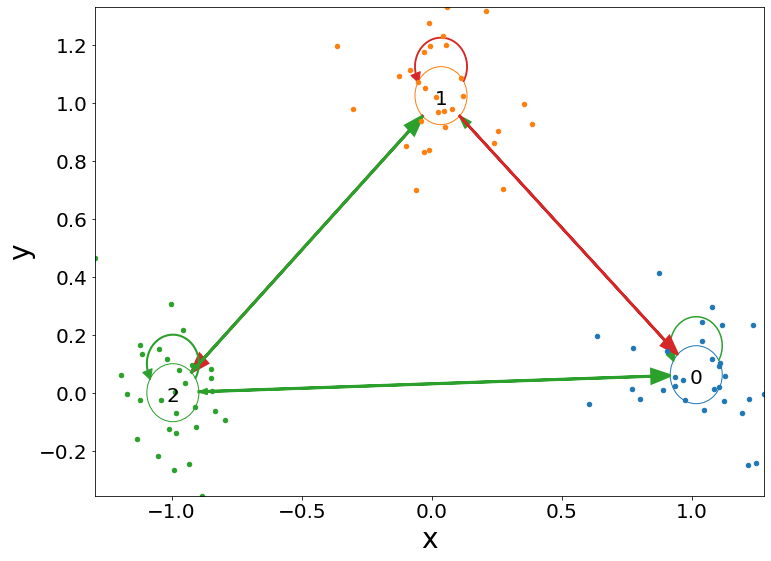

(0.0, 1.0, 0.0, 1.0)

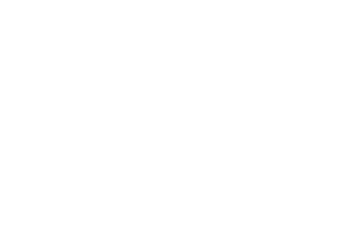

In [11]:
create_plot(rtrbm.W, rtrbm.W_acc-3.8, rf,  coordinates, 0, weight_line_factor=0.25, hiddens_radius=0.1, hidden_weight_thresh=0)
plt.axis('off')

<AxesSubplot:>

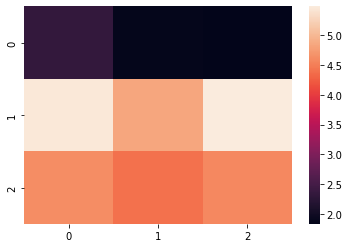

In [187]:
sns.heatmap(rtrbm.W_acc)

### 4 populations

In [292]:
######## Simulation parameters ########
neurons_per_pop = 50
n_pop = 4
n_batches = 300
T = 100
mean_fr = .1

######## Defining coordinate system ########
rads = torch.linspace(0, 2*torch.pi, n_pop+1)
mean_locations_pop = torch.zeros(n_pop, 2)
coordinates = torch.zeros(neurons_per_pop*n_pop, 2)
for i in range(n_pop):
    mean_locations_pop[i, :] = torch.tensor([torch.cos(rads[i]), torch.sin(rads[i])])
    coordinates[neurons_per_pop * i:neurons_per_pop * (i + 1), :] = 0.15 * torch.randn(neurons_per_pop, 2) + mean_locations_pop[i]

######## Start creating data ########
data = torch.zeros(neurons_per_pop*n_pop, T, n_batches)
for batch in range(n_batches):
    
    ######## Creating random input currents and mother trains ########
    t = np.linspace(0, 10*np.pi, T)
    fr = np.zeros((n_pop, T))
    mother = np.zeros((n_pop, T))
    for pop in range(n_pop):
        u = np.random.rand()
        phase = np.random.randn()
        amp = .1*np.random.rand()
        shift = .3*np.random.rand()
        fr[pop, :] = amp*np.sin(phase*(t + 2*np.pi*u)) + shift
        while np.min(fr[pop, :]) < 0:
            u = np.random.rand()
            phase = np.random.randn()
            amp = .1*np.random.rand()
            shift = .3*np.random.rand()
            fr[pop, :] = amp*np.sin(phase*(t + 2*np.pi*u)) + shift
        mother[pop, :] = np.random.poisson(fr[pop, :])


    # Empty data array
    spikes = np.zeros((neurons_per_pop*n_pop, T))
    
    # Excitatory and inhibitory connections
    inh = [[1, 2], [1, 2], [1, 2], [1, 2]]
    exc = [[0, 3], [0, 3], [0, 3], [0, 3]]
    for pop in range(n_pop):
        delete_spikes = np.roll(np.sum(fr[inh[pop], :], 0), 1) * np.ones((neurons_per_pop, T)) >= np.random.uniform(0, 1, size=(neurons_per_pop, T))
        noise = np.random.poisson(np.roll(np.sum(fr[exc[pop], :], 0), 1), (neurons_per_pop, T))
        spikes[pop*neurons_per_pop:(pop+1)*neurons_per_pop, :] = np.tile(mother[pop, :], (neurons_per_pop, 1)) - delete_spikes + noise 
    
    spikes[spikes < 0] = 0
    spikes[spikes > 1] = 1


    data[:, :, batch] = torch.tensor(spikes)

In [411]:
mean_locations_pop

tensor([[ 1.0000e+00,  0.0000e+00],
        [-4.3711e-08,  1.0000e+00],
        [-1.0000e+00, -8.7423e-08],
        [ 1.1925e-08, -1.0000e+00]])

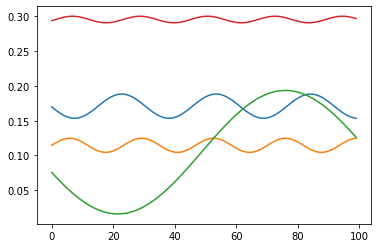

In [288]:
for pop in range(n_pop):
    u = np.random.rand()
    phase = np.random.randn()
    amp = .1*np.random.rand()
    shift = .3*np.random.rand()
    fr[pop, :] = amp*np.sin(phase*(t + 2*np.pi*u)) + shift
    while np.min(fr[pop, :]) < 0:
        u = np.random.rand()
        phase = np.random.randn()
        amp = .1*np.random.rand()
        shift = .3*np.random.rand()
        fr[pop, :] = amp*np.sin(phase*(t + 2*np.pi*u)) + shift
    #mother[pop, :] = np.random.poisson(fr[pop, :])
    plt.plot(fr[pop, :])
    
plt.show()

In [381]:
rtrbm2 = RTRBM(data, N_H=6, device='cpu')
rtrbm2.learn(n_epochs=200, batchsize=100, lr=1e-3, mom=0, wc=0)

 44%|███████████████████████████████████▏                                             | 87/200 [17:58<23:20, 12.40s/it]


KeyboardInterrupt: 

In [ ]:
rtrbm_clone = rtrbm2
rtrbm2.learn(n_epochs=50, batchsize=100, lr=5e-4, mom=0, wc=0)

 76%|█████████████████████████████████████████████████████████▊                  | 38/50 [1:53:15<4:22:40, 1313.34s/it]

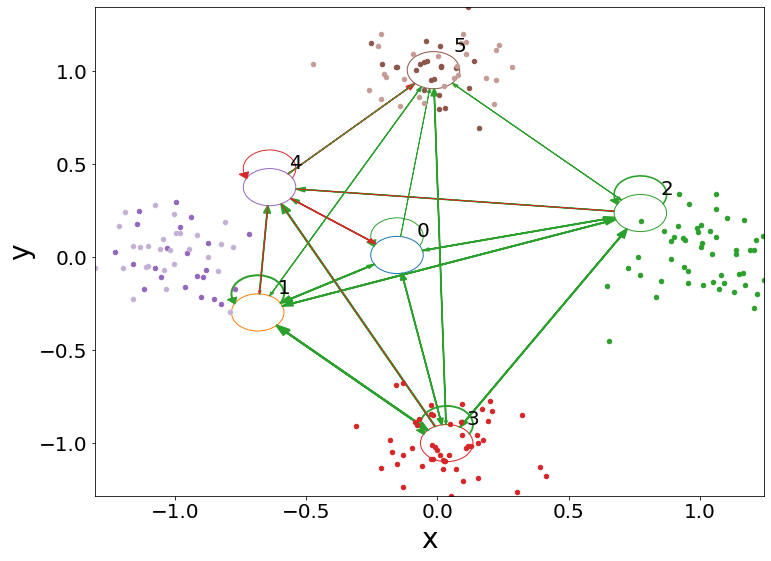

(0.0, 1.0, 0.0, 1.0)

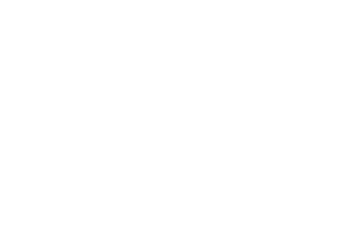

In [405]:
rads = torch.linspace(0, 2*torch.pi, n_pop+1)
mean_locations_pop = torch.zeros(n_pop, 2)
coordinates = torch.zeros(neurons_per_pop*n_pop, 2)
for i in range(n_pop):
    mean_locations_pop[i, :] = torch.tensor([torch.cos(rads[i]), torch.sin(rads[i])])
    coordinates[neurons_per_pop * i:neurons_per_pop * (i + 1), :] = 0.15 * torch.randn(neurons_per_pop, 2) + mean_locations_pop[i]


rf = get_hidden_mean_receptive_fields(rtrbm2.W, coordinates, only_max_conn=False)

create_plot(rtrbm2.W, rtrbm2.W_acc-1.2, rf,  coordinates, 0, weight_line_factor=0.6, hiddens_radius=0.1, hidden_weight_thresh=0)
plt.axis('off')

<AxesSubplot:>

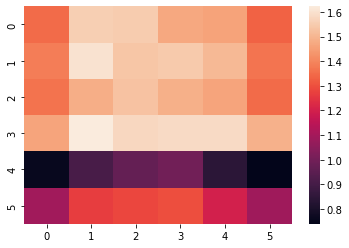

In [391]:
sns.heatmap(rtrbm2.W_acc)

### 6 Populations

In [5]:
######## Simulation parameters ########
neurons_per_pop = 50
n_pop = 6
n_batches = 300
T = 100
mean_fr = .1

######## Defining coordinate system ########
rads = torch.linspace(0, 2*torch.pi, n_pop+1)
mean_locations_pop = torch.zeros(n_pop, 2)
coordinates = torch.zeros(neurons_per_pop*n_pop, 2)
for i in range(n_pop):
    mean_locations_pop[i, :] = torch.tensor([torch.cos(rads[i]), torch.sin(rads[i])])
    coordinates[neurons_per_pop * i:neurons_per_pop * (i + 1), :] = 0.15 * torch.randn(neurons_per_pop, 2) + mean_locations_pop[i]

######## Start creating data ########
data = torch.zeros(neurons_per_pop*n_pop, T, n_batches)
for batch in range(n_batches):
    
    ######## Creating random input currents and mother trains ########
    t = np.linspace(0, 10*np.pi, T)
    fr = np.zeros((n_pop, T))
    mother = np.zeros((n_pop, T))
    for pop in range(n_pop):
        u = np.random.rand()
        phase = np.random.randn()
        amp = .1*np.random.rand()
        shift = .3*np.random.rand()
        fr[pop, :] = amp*np.sin(phase*(t + 2*np.pi*u)) + shift
        while np.min(fr[pop, :]) < 0:
            u = np.random.rand()
            phase = np.random.randn()
            amp = .1*np.random.rand()
            shift = .3*np.random.rand()
            fr[pop, :] = amp*np.sin(phase*(t + 2*np.pi*u)) + shift
        mother[pop, :] = np.random.poisson(fr[pop, :])


    # empty data array
    spikes = np.zeros((neurons_per_pop*n_pop, T))
    
    #Excitatory and inhibitory connections
    inh = [[0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2], [0, 1, 2]]
    exc = [[3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5], [3, 4, 5]]
    for pop in range(n_pop):
        delete_spikes = np.roll(np.sum(fr[inh[pop], :], 0), 1) * np.ones((neurons_per_pop, T)) >= np.random.uniform(0, 1, size=(neurons_per_pop, T))
        noise = np.random.poisson(np.roll(np.sum(fr[exc[pop], :], 0), 1), (neurons_per_pop, T))
        spikes[pop*neurons_per_pop:(pop+1)*neurons_per_pop, :] = np.tile(mother[pop, :], (neurons_per_pop, 1)) - delete_spikes + noise
    spikes[spikes < 0] = 0
    spikes[spikes > 1] = 1


    data[:, :, batch] = torch.tensor(spikes)

<AxesSubplot:>

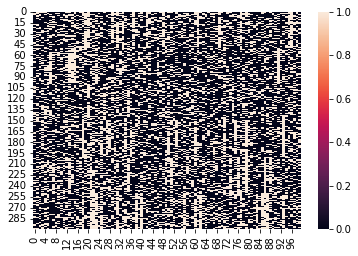

In [6]:
sns.heatmap(data[:,:,0])

In [17]:
rtrbm6 = RTRBM(data, N_H=6, device='cuda')
rtrbm6.learn(n_epochs=500, batchsize=10, lr=1e-3, mom=.7, wc=.0002)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [2:00:38<00:00, 14.48s/it]


<AxesSubplot:title={'center':'Reconstruction error of RTRBM during training'}, xlabel='epochs', ylabel='normalised reconstruction error'>

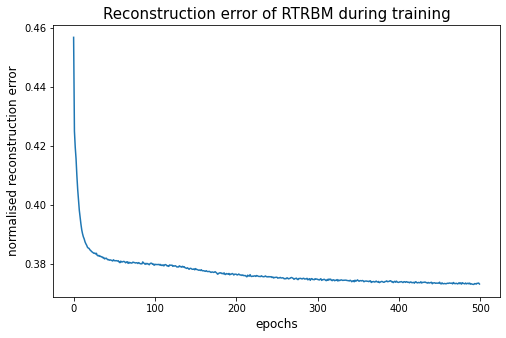

In [18]:
plot_reconstruction_error(rtrbm6.errors)

In [24]:
rtrbm6.b_H

tensor([[-12.9032,  28.0878, -13.1664,  18.5695,  23.9409,  38.1124]],
       device='cuda:0')

<AxesSubplot:title={'center':'$U$'}>

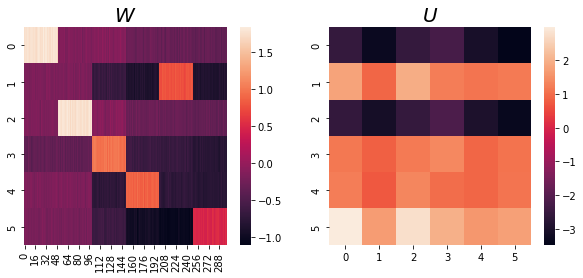

In [20]:
plot_weights(rtrbm6.W.cpu(), rtrbm6.W_acc.cpu())

In [26]:
pickle.dump(rtrbm6, open(r'C:\Users\CP\OneDrive\RU\Intern\rtrbm_master\results\6_pop_sin', 'wb'))

<AxesSubplot:>

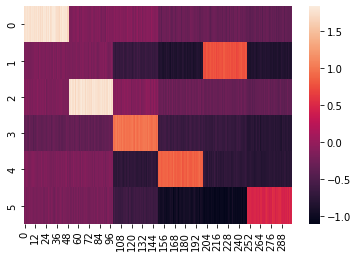

In [27]:
check1 = pickle.load(open(r'C:\Users\CP\OneDrive\RU\Intern\rtrbm_master\results\6_pop_sin', 'rb'))
sns.heatmap(check1.W.cpu())

<AxesSubplot:xlabel='x', ylabel='y'>

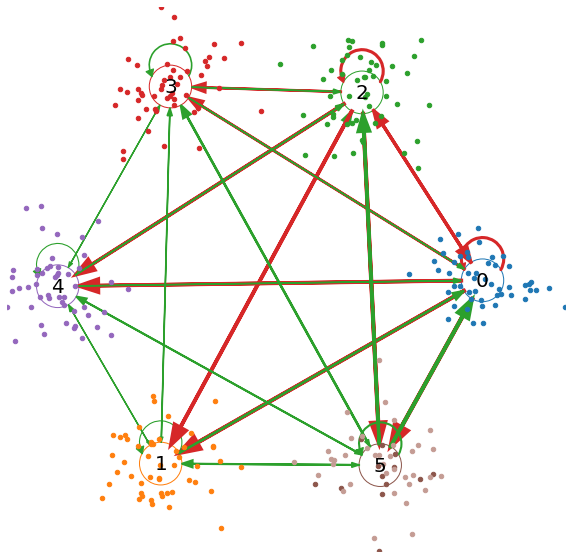

In [23]:
plot_hidden_structure(rtrbm6.W.cpu(), rtrbm6.W_acc.cpu(), n_pop=6, only_max_conn=True, weight_line_factor=0.2, hiddens_radius=.1)

<AxesSubplot:>

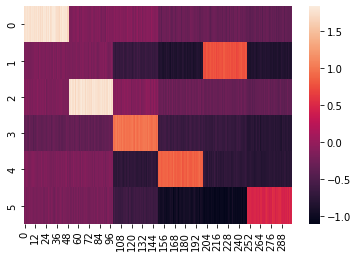

In [28]:
sns.heatmap(check1.W.cpu())

In [29]:
torch.mean(data, (1, 2))

tensor([0.3071, 0.3107, 0.3135, 0.3124, 0.3100, 0.3109, 0.3111, 0.3097, 0.3073,
        0.3070, 0.3121, 0.3148, 0.3090, 0.3102, 0.3096, 0.3165, 0.3110, 0.3140,
        0.3088, 0.3110, 0.3121, 0.3086, 0.3079, 0.3100, 0.3122, 0.3081, 0.3148,
        0.3089, 0.3087, 0.3131, 0.3093, 0.3064, 0.3088, 0.3092, 0.3133, 0.3081,
        0.3150, 0.3077, 0.3061, 0.3110, 0.3118, 0.3114, 0.3114, 0.3172, 0.3112,
        0.3068, 0.3085, 0.3115, 0.3124, 0.3090, 0.3157, 0.3096, 0.3143, 0.3104,
        0.3113, 0.3130, 0.3090, 0.3082, 0.3114, 0.3097, 0.3150, 0.3096, 0.3124,
        0.3128, 0.3107, 0.3111, 0.3122, 0.3101, 0.3124, 0.3080, 0.3116, 0.3109,
        0.3093, 0.3118, 0.3137, 0.3095, 0.3105, 0.3130, 0.3131, 0.3142, 0.3117,
        0.3052, 0.3130, 0.3123, 0.3120, 0.3050, 0.3127, 0.3113, 0.3100, 0.3107,
        0.3093, 0.3082, 0.3130, 0.3082, 0.3080, 0.3135, 0.3073, 0.3138, 0.3132,
        0.3091, 0.3089, 0.3160, 0.3105, 0.3080, 0.3100, 0.3078, 0.3139, 0.3070,
        0.3060, 0.3098, 0.3076, 0.3080, 

In [44]:
v_rtrbm = torch.zeros(check1.N_V, 10, 1000, device='cuda')
h_rtrbm = torch.zeros(check1.N_H, 10, 1000, device='cuda')

for i in tqdm(range(1000)):
    random_config = torch.randint(0, 2, (check1.N_V,), device='cuda', dtype=torch.float)
    v_rtrbm[:, :, i], h_rtrbm[:, :, i] = check1.sample(random_config, chain=10, pre_gibbs_k=100, gibbs_k=10, disable_tqdm=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:43<00:00,  4.48it/s]


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

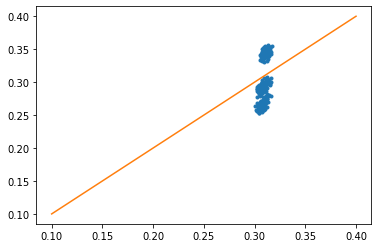

In [45]:
V_data_mean = torch.mean(data, (1, 2))
V_sampled_mean_rtrbm = torch.mean(v_rtrbm, (1, 2))

plt.plot(V_data_mean.cpu(), V_sampled_mean_rtrbm.cpu(), '.')
plt.plot([.1, .4], [.1, .4], '-')
plt.set_title('RTRBM')
plt.set_xlabel('true')
plt.set_ylabel('sampled')

### 6 populations, better firing rate dist

In [2]:
######## Simulation parameters ########
neurons_per_pop = 50
n_pop = 6
n_batches = 300
T = 100
mean_fr = .1

######## Defining coordinate system ########
rads = torch.linspace(0, 2*torch.pi, n_pop+1)
mean_locations_pop = torch.zeros(n_pop, 2)
coordinates = torch.zeros(neurons_per_pop*n_pop, 2)
for i in range(n_pop):
    mean_locations_pop[i, :] = torch.tensor([torch.cos(rads[i]), torch.sin(rads[i])])
    coordinates[neurons_per_pop * i:neurons_per_pop * (i + 1), :] = 0.15 * torch.randn(neurons_per_pop, 2) + mean_locations_pop[i]

######## Start creating data ########
data = torch.zeros(neurons_per_pop*n_pop, T, n_batches)
for batch in range(n_batches):
    
    ######## Creating random input currents and mother trains ########
    t = np.linspace(0, 10*np.pi, T)
    fr = np.zeros((n_pop, T))
    mother = np.zeros((n_pop, T))
    for pop in range(n_pop):
        u = np.random.rand()
        phase = np.random.randn()
        amp = .1*np.random.rand()
        shift = .3*np.random.rand()
        fr[pop, :] = amp*np.sin(phase*(t + 2*np.pi*u)) + shift
        while np.min(fr[pop, :]) < 0:
            u = np.random.rand()
            phase = np.random.randn()
            amp = .1*np.random.rand()
            shift = .3*np.random.rand()
            fr[pop, :] = amp*np.sin(phase*(t + 2*np.pi*u)) + shift
        mother[pop, :] = np.random.poisson(fr[pop, :])


    # empty data array
    spikes = np.zeros((neurons_per_pop*n_pop, T))
    
    #Excitatory and inhibitory connections
    inh = [[0], [0], [0], [0], [0], [0]]
    exc = [[3], [3], [3], [3], [3], [3]]
    for pop in range(n_pop):
        delete_spikes = np.roll(np.sum(fr[inh[pop], :], 0), 1) * np.ones((neurons_per_pop, T)) >= np.random.uniform(0, 1, size=(neurons_per_pop, T))
        noise = np.random.poisson(np.roll(np.sum(fr[exc[pop], :], 0), 1), (neurons_per_pop, T))
        temp = np.tile(mother[pop, :], (neurons_per_pop, 1)) - delete_spikes + noise
        spikes[pop*neurons_per_pop:(pop+1)*neurons_per_pop, :] = temp[np.argsort(np.mean(temp, 1)), :]
    spikes[spikes < 0] = 0
    spikes[spikes > 1] = 1


    data[:, :, batch] = torch.tensor(spikes)

D:\Programs\anaconda\envs\rtrbm\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'mean activation')

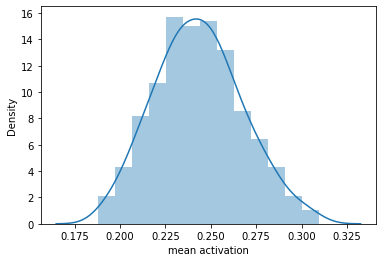

In [3]:
sns.distplot(torch.mean(data, (1, 2)))
plt.xlabel('mean activation')

<AxesSubplot:title={'center':'Spiking pattern'}, xlabel='time', ylabel='# neuron'>

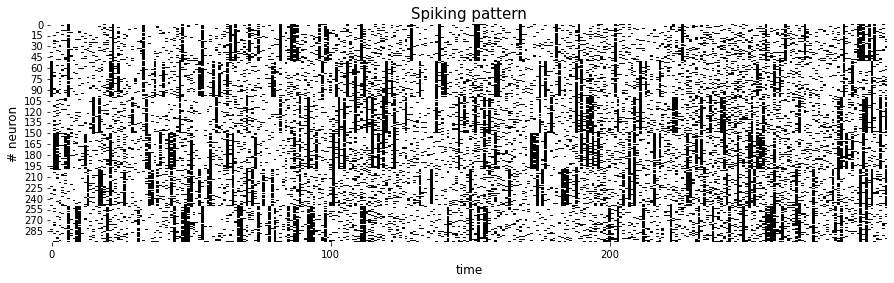

In [4]:
raster_plot(torch.cat((data[:,:,0], data[:,:,1], data[:,:,2]), 1))

In [6]:
rtrbm6s = RTRBM(data, N_H=6, device='cpu')
rtrbm6s.learn(n_epochs=3000, batchsize=10, lr=1e-4)

  0%|          | 2/3000 [00:52<21:52:52, 26.27s/it]


KeyboardInterrupt: 

<AxesSubplot:title={'center':'$U$'}>

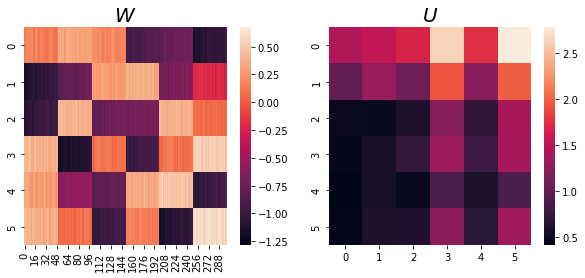

In [54]:
plot_weights(rtrbm6s.W.cpu(), rtrbm6s.W_acc.cpu())

<AxesSubplot:title={'center':'Reconstruction error of RTRBM during training'}, xlabel='epochs', ylabel='normalised reconstruction error'>

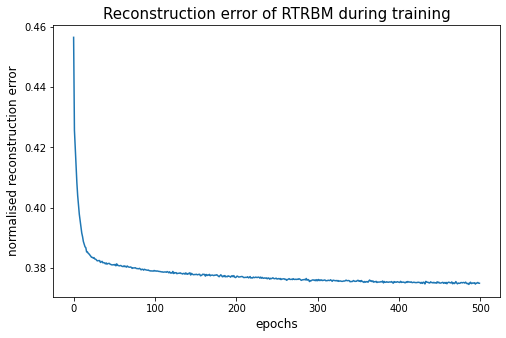

In [55]:
plot_reconstruction_error(rtrbm6s.errors)

In [38]:
def sample(self,
           v_start,
           AF=torch.sigmoid,
           chain=50,
           pre_gibbs_k=100,
           gibbs_k=20,
           mode=1,
           disable_tqdm=False):

    vt = torch.zeros(self.N_V, chain, dtype=self.dtype, device=self.device)
    rt = torch.zeros(self.N_H, chain, dtype=self.dtype, device=self.device)

    rt[:, 0] = AF(torch.matmul(self.W, v_start) + self.b_init).reshape(50,)
    vt[:, 0] = v_start
    for t in tqdm(range(1, chain), disable=disable_tqdm):
        v = vt[:, t - 1]

        # it is important to keep the burn-in inside the chain loop, because we now have time-dependency
        for kk in range(pre_gibbs_k):
            h = torch.bernoulli(AF(torch.matmul(self.W, v).T + self.b_H + torch.matmul(self.W_acc, rt[:, t - 1]))).T
            v = torch.bernoulli(AF(torch.matmul(self.W.T, h) + self.b_V.T))

        vt_k = torch.zeros(self.N_V, gibbs_k, dtype=self.dtype, device=self.device)
        ht_k = torch.zeros(self.N_H, gibbs_k, dtype=self.dtype, device=self.device)
        for kk in range(gibbs_k):
            h = torch.bernoulli(AF(torch.matmul(self.W, v).T + self.b_H + torch.matmul(self.W_acc, rt[:, t - 1]))).T
            v = torch.bernoulli(AF(torch.matmul(self.W.T, h) + self.b_V.T))
            vt_k[:, kk] = v.T
            ht_k[:, kk] = h.T

        if mode == 1:
            vt[:, t] = vt_k[:, -1]
        if mode == 2:
            vt[:, t] = torch.mean(vt_k, 1)
        if mode == 3:
            E = torch.sum(ht_k * (torch.matmul(self.W, vt_k)), 0) + torch.matmul(self.b_V, vt_k) + torch.matmul(
                self.b_H, ht_k) + torch.matmul(torch.matmul(self.W_acc, rt[:, t - 1]).T, ht_k)
            idx = torch.argmax(E)
            vt[:, t] = vt_k[:, idx]

        rt[:, t] = AF(torch.matmul(self.W, vt[:, t]) + self.b_H + torch.matmul(self.W_acc, rt[:, t - 1]))

    return vt, rt


In [9]:
import numpy as np
from math import cos, sin, atan2
from palettable.tableau import Tableau_10, Tableau_20
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, RegularPolygon
from numpy import radians as rad
import torch



def plot_hidden_structure(VH,
                          HH,
                          rf=None,
                          coords=None,
                          n_pop=10,
                          markersize_visibles=20,
                          hiddens_radius=0.02,
                          weight_line_factor=1,
                          hidden_weight_thresh=0,
                          only_max_conn=True,
                          axis_off=True,
                          figsize=(10,10)):

    if coords is None:
        neurons_per_pop = VH.shape[1] // n_pop
        rads = torch.linspace(0, 2 * torch.pi, n_pop + 1)
        mean_locations_pop = torch.zeros(n_pop, 2)
        coordinates = torch.zeros(neurons_per_pop * n_pop, 2)
        for i in range(n_pop):
            mean_locations_pop[i, :] = torch.tensor([torch.cos(rads[i]), torch.sin(rads[i])])
            coordinates[neurons_per_pop * i:neurons_per_pop * (i + 1), :] = 0.15 * torch.randn(neurons_per_pop, 2) + \
                                                                            mean_locations_pop[i]
        coords = coordinates

    if rf is None:
        rf = get_hidden_mean_receptive_fields(VH, coords, only_max_conn=only_max_conn)

    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x_hidden_mean_receptive_fields = rf[:, 0]
    y_hidden_mean_receptive_fields = rf[:, 1]

    N_H = HH.shape[0]
    for h in range(N_H):
        draw_neuron(x_hidden_mean_receptive_fields[h], y_hidden_mean_receptive_fields[h], hiddens_radius, id=h)

    for h in range(N_H):
        for hh in range(N_H):
            if abs(HH[h, hh]) > hidden_weight_thresh:
                if h < hh:
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h], y_hidden_mean_receptive_fields[h],
                                             x_hidden_mean_receptive_fields[hh], y_hidden_mean_receptive_fields[hh],
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)
                else:
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h], y_hidden_mean_receptive_fields[h],
                                             x_hidden_mean_receptive_fields[hh], y_hidden_mean_receptive_fields[hh],
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)

    plot_VH_connections(plt.gca(), VH, coords, markersize=markersize_visibles)

    plt.gca().set_xlim(torch.min(coords[:, 0]), torch.max(coords[:, 0]))
    plt.gca().set_ylim(torch.min(coords[:, 1]), torch.max(coords[:, 1]))

    plt.plot(coords[:, 0], coords[:, 1], 'g.', markersize=1, zorder=-10)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    if axis_off:
        plt.axis('off')
    return plt.gca()



def create_plot(VH, HH, rf, coords, dy, dx=0, markersize_visibles=20, hiddens_radius=0.02, weight_line_factor=1, hidden_weight_thresh=0):
    plt.figure(figsize=(12, 9))
    x_hidden_mean_receptive_fields = rf[:, 0]
    y_hidden_mean_receptive_fields = rf[:, 1]

    N_H = HH.shape[0]
    for h in range(N_H):
        draw_neuron(x_hidden_mean_receptive_fields[h], y_hidden_mean_receptive_fields[h], hiddens_radius, id=h)

    for h in range(N_H):
        for hh in range(N_H):
            if abs(HH[h, hh]) > hidden_weight_thresh:
                if h < hh:
                    dy = -dy
                    dx = -dx
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h]+dx, y_hidden_mean_receptive_fields[h] + dy,
                                             x_hidden_mean_receptive_fields[hh]+dx, y_hidden_mean_receptive_fields[hh] + dy,
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)
                else:
                    dy = abs(dy)
                    dx = abs(dx)
                    line_between_two_neurons(x_hidden_mean_receptive_fields[h]+dx, y_hidden_mean_receptive_fields[h] + dy,
                                             x_hidden_mean_receptive_fields[hh]+dx, y_hidden_mean_receptive_fields[hh] + dy,
                                             hiddens_radius, weight=HH[h, hh], weight_line_factor=weight_line_factor)

    plot_VH_connections(plt.gca(), VH, coords, markersize=markersize_visibles)

    plt.gca().set_xlim(torch.min(coords[:, 0]), torch.max(coords[:, 0]))
    plt.gca().set_ylim(torch.min(coords[:, 1]), torch.max(coords[:, 1]))

    plt.plot(coords[:, 0], coords[:, 1], 'g.', markersize=1, zorder=-10)
    plt.xlabel('x', fontsize=28)
    plt.ylabel('y', fontsize=28)
    plt.tick_params(axis='both', which='major', labelsize=20)

    plt.show()



def draw_neuron(x, y, neuron_radius, id=-1):
    # circle = plt.Circle((x, y), radius=neuron_radius, fill=False, color=Tableau_20.mpl_colors[2*id])
    # plt.gca().add_patch(circle)
    # plt.gca().text(x, y-(neuron_radius/4), str(id), size=neuron_radius*1000, ha='center')

    circle = plt.Circle((x, y), radius=neuron_radius, fill=False, color=Tableau_20.mpl_colors[2 * id])
    plt.gca().add_patch(circle)
    plt.gca().text(x, y-0.03, str(id), ha='center', fontsize=20)


def line_between_two_neurons(neuron1_x, neuron1_y, neuron2_x, neuron2_y, neuron_radius, weight=0.4,
                             weight_line_factor=1):
    angle = atan2(neuron2_x - neuron1_x, neuron2_y - neuron1_y)
    x_adjustment = neuron_radius * sin(angle)
    y_adjustment = neuron_radius * cos(angle)

    # assign colors to lines depending on the sign of the weight
    color = Tableau_10.mpl_colors[3]
    if weight > 0: color = Tableau_10.mpl_colors[2]

    # assign different linewidths to lines depending on the size of the weight
    abs_weight = abs(weight)
    linewidth = 2 * abs_weight * weight_line_factor

    # draw self-connecting arrow
    if neuron1_x == neuron2_x:
        drawCirc(plt.gca(), neuron_radius * 2, neuron1_x, neuron1_y, -30, 230, color_=color, lw=3 * linewidth)

    # draw arrow
    else:
        plt.gca().arrow(neuron1_x + x_adjustment, neuron1_y + y_adjustment,
                        neuron2_x - neuron1_x - 2 * x_adjustment, neuron2_y - neuron1_y - 2 * y_adjustment,
                        lw=3 * linewidth, color=color, length_includes_head=True, head_width=linewidth/20, overhang=0)

def drawCirc(ax, radius, centX, centY, angle_, theta2_, color_='black', lw=1):
    # Line
    if lw > 0.1:
        arc = Arc([centX, centY + radius / 2], radius, radius, angle=angle_,
                  theta1=0, theta2=theta2_, capstyle='round', linestyle='-', lw=lw, color=color_)
        ax.add_patch(arc)

        # Create the arrow head
        endX = centX + (radius / 2) * np.cos(rad(theta2_ + angle_))  # Do trig to determine end position
        endY = centY + (radius / 2) * np.sin(rad(theta2_ + angle_))

        ax.add_patch(RegularPolygon((endX, endY + radius / 2),  # (x,y)
                                    3,  # number of vertices
                                    radius / 9,  # radius
                                    rad(angle_ + theta2_),  # orientation
                                    color=color_))


def plot_VH_connections(ax, VH, coordinates, strong_thresh=0.5, markersize=2):
    N_H, N_V = VH.shape
    max_hidden_connection = torch.max(VH, 0)[1]

    for h in range(N_H):
        ax.scatter(coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) > strong_thresh), 0],
                   coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) > strong_thresh), 1],
                   color=Tableau_20.mpl_colors[(2 * h) % 20], s=markersize)

        ax.scatter(coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) < strong_thresh), 0],
                   coordinates[(max_hidden_connection == h) * (torch.abs(VH[h, :]) < strong_thresh), 1],
                   color=Tableau_20.mpl_colors[(2 * h + 1) % 20], s=markersize)
        ax.set_xlabel('x', fontsize=28)
        ax.set_ylabel('y', fontsize=28)
        ax.tick_params(axis='both', which='major', labelsize=20)
        
def get_hidden_mean_receptive_fields(weights, coordinates, only_max_conn=False):

    VH = weights.detach().clone()

    if only_max_conn is False: VH[VH < 0] = 0

    n_dimensions = torch.tensor(coordinates.shape).shape[0]
    N_H = VH.shape[0]

    max_hidden_connection = torch.max(VH, 0)[1]
    if n_dimensions == 1:
        rf = torch.zeros(N_H)
        for h in range(N_H):
            if only_max_conn:
                v_idx = (max_hidden_connection == h)
                rf[h] = torch.mean(coordinates[v_idx])
            else:
                rf[h] = torch.sum(VH[h, :] * coordinates / torch.sum(VH[h, :]))
    else:
        rf = torch.zeros(N_H, n_dimensions)
        for i in range(n_dimensions):
            for h in range(N_H):
                if only_max_conn:
                    v_idx = (max_hidden_connection == h)
                    rf[h, i] = torch.mean(coordinates[v_idx, i])
                else:
                    rf[h, i] = torch.sum(VH[h, :] * coordinates[:, i] / torch.sum(VH[h, :]))

    return rf



In [247]:
for i in range(100):
    if i % 10 == 10:
        print('hoi')

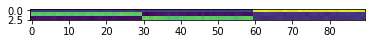

In [248]:
plt.imshow(rtrbm.W)